# Recording along a trajectory

In this tutorial, you will learn to take advantage of navipy and the rendering modules (blender) to render what has been seen by the animal along its trajectory. 

To render along a trajectory, you will need to have:
* the environment (a blender file)
* the trajectory formatted for navipy (see 02-recording-animal-trajectory)

## Ploting the position and orientation of the animal

The trajectory of the animal can be plotted in different manners. Here we will look at two representations:

* Timeseries
* Lollipop

### Timeseries

Plotting a trajectories along the time allows to visualize temporal dependencies between each component of the saccade. For example, flying insects engage in an active vision strategy containing saccades and intersaccades. By ploting the euler's angle along the time, one can observe a step like plot, i.e. a succesion of plateaus (interssacades) and quick change in the angle (saccade).

The positional and orientational components of the trajectories have different units (unit of distance and unit of angle, respectively). Therefore two different y-axis are necessary. 

We first load a trajectory:

In [1]:
from navipy.trajectories import Trajectory
import pkg_resources
# Use the trafile from the resources
# You can adapt this code, by changing trajfile 
# with your own trajectory file
trajfile = pkg_resources.resource_filename(
    'navipy',
    'resources/sample_experiment/Lobecke_JEB_2018/Y101_OBFlight_0001.csv')
trajectory = Trajectory().read_csv(trajfile)

5.923315763473511
17.265806674957275
3.623591423034668


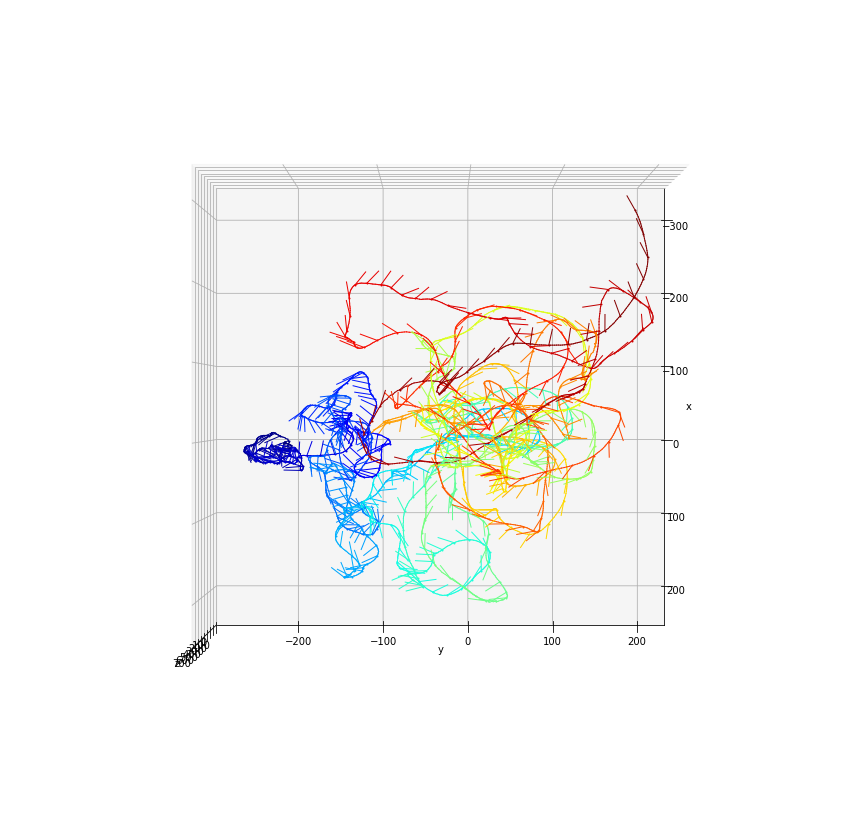

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(90, 0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
trajectory.lollipops(ax, step_lollipop=10, lollipop_tail_length=20)

For blender

bpy.context.scene.frame_start = 7000
bpy.context.scene.frame_end = 7000 # Change the number of frames
bpy.context.scene.frame_current = 2




## Checking the position of the animal within the environment

Rendering a trajectory will take time, and thus we want to check - prior to rendering - the correctness of the animal within the environment. The best way to check, is to overlay the trajectory within the blender world, and by rotating the environment, one could look for: part of the trajectory crossing objects, a wrong height, etc... 

To overlay the trajectory within your blender environment you can use the following command:

```bash
blendoverlaytraj --blenderworld='pathtomyworld.blend' 
                 --trajectory='pathtomytrajectory.csv'
```

here ```pathtomyworld.blend``` and ```'pathtomytrajectory.csv'``` are the path to your blender environment and your trajectory respectively.

> The overlayed trajectory will not be rendered, because it is a simple line and its rendering is disable. If you want
> to render the trajectory, you can bevel the trajectory with a circle for example. It will create a extrude the circle
> along the trajectory and thus creating a 3D shaped. (Don't forget to enable rendering)


## Rendering the trajectory in a database

Once we know that the trajectory is correctly placed within the environment, it is time to render along the trajectory. We, however, recommand to render only the first view frame of your trajectory first in order to check for the orientation. Indeed we only checked the position of the animal, but not its orientation. Navipy supports all 24 Euler convention, and also quaternion. You need to figure out which one you used. Sadly we did not find until now an easy way to do it... Having said that, if you "only" tracked the yaw of the animal, you can safely use the 'rzyx' convention, here alpha_0 of your trajectory correspond to the yaw of the animal and all other angles are set to 0. 

```bash
blendalongtraj --output-file='pathtodatabase.db' 
               --blenderworld='pathtomyworld.blend' 
               --trajectory='pathtomytrajectory.csv'
```

here ```pathtomyworld.blend```, ```'pathtomytrajectory.csv'```, ```pathtodatabase.db``` are the path to your blender environment, to your trajectory, and to the file to store the iamges respectively.


## Database to list of images

The database store all position-orientation and images along the trajectory in a single file. On the one hand, it is convenient, because you always know at which position and in which orientation an image has been rendered. On the other hand, we can not easily visualise the images. 

To convert the database into an image sequence or list, you can run the following script in a ipython notebook (Don't forget to change the variable ```database``` to the path of your trajectory

In [9]:
# Load the necessary modules
from navipy.database import DataBase
from matplotlib.image import imsave
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the database, and specify the
# the output directory to save the list
# of images
import pkg_resources
# Use the trafile from the resources
# You can adapt this code, by changing trajfile 
# with your own trajectory file
database = pkg_resources.resource_filename(
    'navipy',
    'resources/database.db')
database_dir, _ = os.path.splitext(database)
if not os.path.exists(database_dir):
    os.makedirs(database_dir)
database_template = os.path.join(database_dir, 'frame_{}.png')
mydb = DataBase(database)

for rowid, cposorient in mydb.posorients.iterrows():
    my_scene = mydb.scene(rowid=int(rowid))
    # Note on new database version
    # my_scene = mydb.scene(posorient=cposorient)
    
    to_plot_im = my_scene[:, :, :3, 0]
    to_plot_im -= to_plot_im.min()
    to_plot_im /= to_plot_im.max()
    to_plot_im = to_plot_im * 255
    
    to_plot_im = to_plot_im.astype(np.uint8)
    
    to_plot_dist = my_scene[:, :, 3, 0]
    
    imsave(database_template.format(rowid), to_plot_im[::-1,...] )

Could not index by frame_i


## Plotting an image from the database

/home/bolirev/.virtualenv/toolbox-navigation/lib/python3.6/site-packages/matplotlib-2.1.0-py3.6-linux-x86_64.egg/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


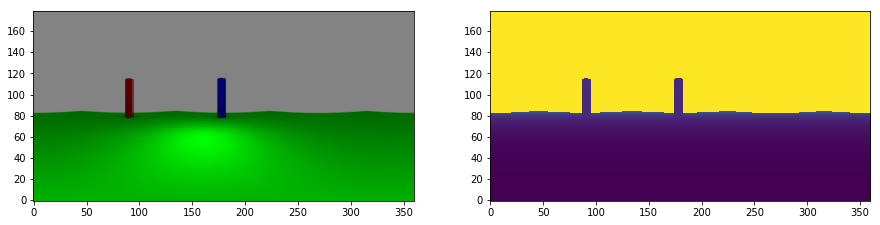

In [8]:
%matplotlib inline
my_scene = mydb.scene(rowid=2)
f, axarr = plt.subplots(1, 2, figsize=(15, 4))

to_plot_im = my_scene[:, :, :3, 0].astype(float)
to_plot_im -= to_plot_im.min()
to_plot_im /= to_plot_im.max()
to_plot_im = to_plot_im * 255
to_plot_im = to_plot_im.astype(np.uint8)
to_plot_dist = my_scene[:, :, 3, 0]

ax = axarr[0]
ax.imshow(to_plot_im)
ax.invert_yaxis()

ax = axarr[1]
ax.imshow(to_plot_dist)
ax.invert_yaxis()

f.show()